This program simulates trust degradation and countermeasures in robots, then I used QUBO models for assigning robots to tasks under trust contraints.

# Luke's comments
Giselle,

I've taken a look at your code and provided comments where I could see things that could be improved.  I don't think you're fragile, but I want to reinforce that I wouldn't have taken the time if this wasn't already good.  Don't take my individual criticisms as a critique of your overall work.  Additionally, I can't claim to have made a complete review of the work. However, I'm more than happy to provide iterative reviews.  Reinforcement systems are hard, and this is a solid start.

THANK YOU MILLER!

appreciate the comments

In [114]:
import random
import matplotlib.pyplot as plt
import numpy as np
#imports for qubo
!pip install dimod
import dimod
import seaborn as sns

baseline for the overall project

# **07/03 Changes and Question:**

Adjusted pentalty to 0.02 (0.015, 0.025), reward 0.05 (0.04, 0.06), comproise rate to 0.02 (0.05) and countermeasures to 3 successes.

How would I know which combination of penalty and rewards will help my researach or show a more realistic enviorment?

In [115]:
#parameters
num_agents = 100
total_rounds = 1000
compromise_rate = 0.02 #also adjusted to 0.05
penalty = 0.02 # also adjusted to 0.015 and 0.025
reward = 0.05 # alse adjusted to 0.04 and 0.06
use_countermeasures = True

In [116]:
#robot starts with a random trust score
robots = {}
for i in range(1, num_agents + 1):
    robot_id = f"Robot_{i}"
    initial_trust = round(random.uniform(0.3, 0.95), 2)
    robots[robot_id] = {
        'trust': initial_trust,
        'trust_history': [initial_trust],
        'compromised': True,
        'success_count': 0,
        'fail_count': 0
    }

### Luke's comments:
First of all.  It's very nice to read code with explanatory variables and well commmented code.  Thank you for not sharing cryptic code. I run into that a lot, and this is a breath of fresh air.|

In [117]:
#tracks how many robots are compromised and how many tasks succeed/fail over time
compromised_counts = []
success_counts = []
fail_counts = []

In [118]:
for round_num in range(total_rounds):

    #randomly chooses 10% of robots to compromise
    num_compromised = int(num_agents * compromise_rate)
    compromised_ids = random.sample(list(robots.keys()), num_compromised)

    round_compromised = 0
    round_success = 0
    round_fail = 0

    for robot_id in robots:
        robot = robots[robot_id]
        robot['compromised'] = robot_id in compromised_ids
        #checks if the robot is compromised this round
        if robot['compromised']:
          #compromised robot loses trust
            round_compromised += 1
            robot['fail_count'] += 1
            robot['trust'] = max(0.0, robot['trust'] - penalty)
        else:
          #robots try to complete tasks
            if random.random() < robot['trust']:
              #task completed it increases trust
                round_success += 1
                robot['success_count'] += 1
                robot['trust'] = min(1.0, robot['trust'] + reward)
            else:
              #failed tsks decreses trust
                round_fail += 1
                robot['fail_count'] += 1
                robot['trust'] = max(0.0, robot['trust'] - penalty)

        # defense measures -----------------------
        if use_countermeasures:
            #recover if robot has success
            if robot['success_count'] > 3 and robot['trust'] < 0.9:
                robot['trust'] += 0.02

            #trust floor
            if round_num % 200 == 0:
                robot['trust'] = max(robot['trust'], 0.2)

        #logs the round's trust score
        robot['trust_history'].append(robot['trust'])

    #records the rounds stats
    compromised_counts.append(round_compromised)
    success_counts.append(round_success)
    fail_counts.append(round_fail)

print(f"{total_rounds} simulation rounds done")

1000 simulation rounds done


visualizations of results

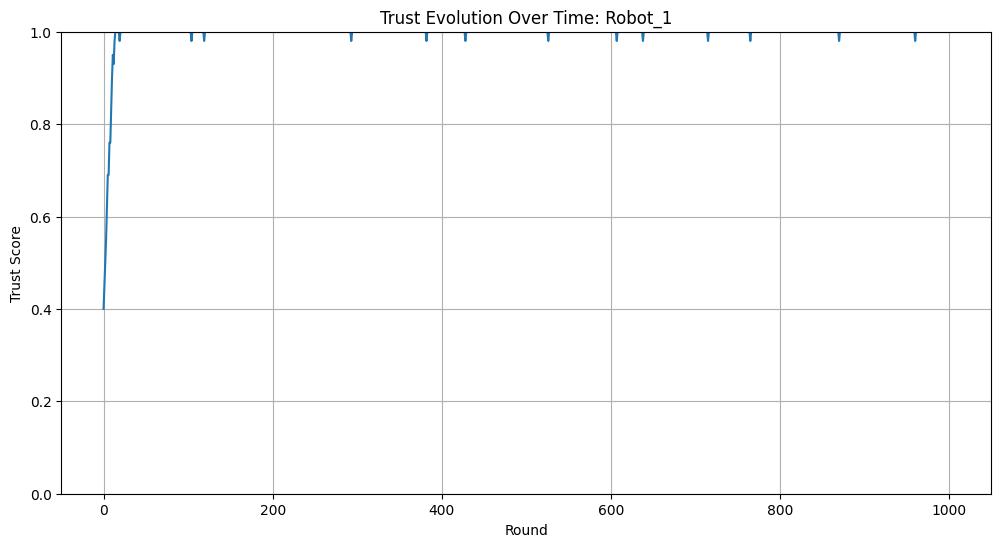

In [119]:
#shows trust score over time for one robot
example_robot_id = "Robot_1"
plt.figure(figsize=(12,6))
plt.plot(robots[example_robot_id]['trust_history'])
plt.title(f"Trust Evolution Over Time: {example_robot_id}")
plt.xlabel("Round")
plt.ylabel("Trust Score")
plt.ylim(0, 1)
plt.grid()
plt.show()

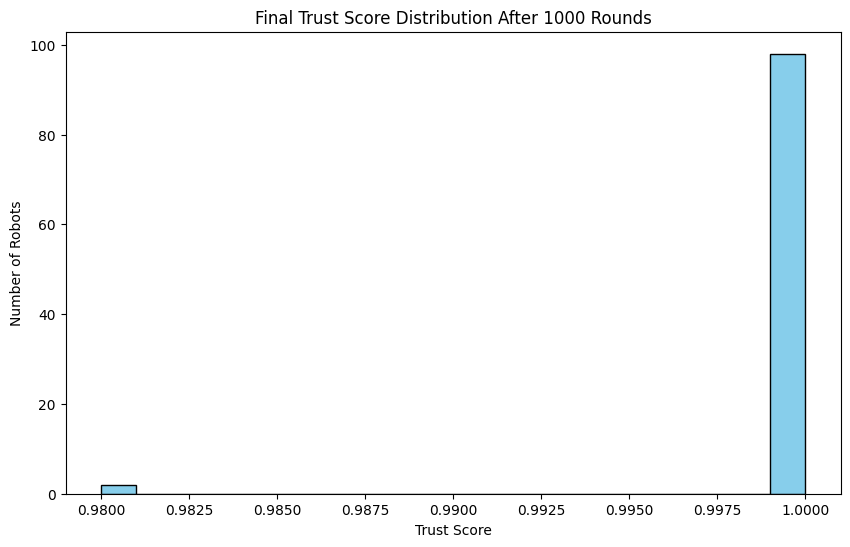

In [120]:
#shows overall distribution of trust scores after 1k ronds
final_trust_scores = [robots[robot_id]['trust'] for robot_id in robots]
plt.figure(figsize=(10,6))
plt.hist(final_trust_scores, bins=20, color='skyblue', edgecolor='black')
plt.title("Final Trust Score Distribution After 1000 Rounds")
plt.xlabel("Trust Score")
plt.ylabel("Number of Robots")
plt.show()

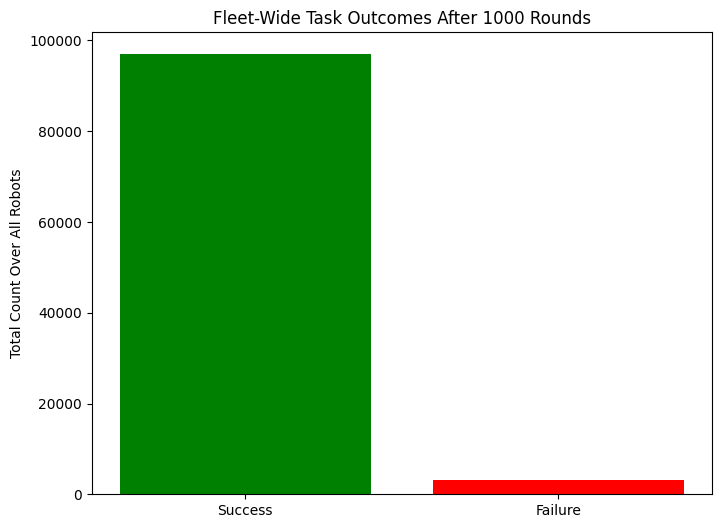

Total Successes: 96948
Total Failures: 3052


In [121]:
#shows successful and failed tasks
total_success = sum(robots[robot_id]['success_count'] for robot_id in robots)
total_fail = sum(robots[robot_id]['fail_count'] for robot_id in robots)

plt.figure(figsize=(8,6))
plt.bar(['Success', 'Failure'], [total_success, total_fail], color=['green', 'red'])
plt.title("Fleet-Wide Task Outcomes After 1000 Rounds")
plt.ylabel("Total Count Over All Robots")
plt.show()

print(f"Total Successes: {total_success}")
print(f"Total Failures: {total_fail}")

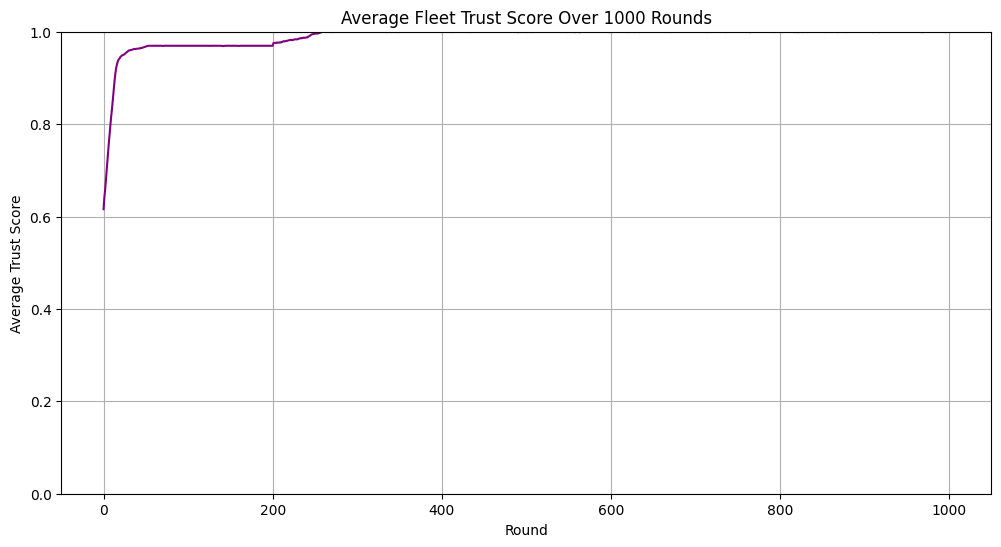

In [122]:
#shows average trust over time
rounds = len(next(iter(robots.values()))['trust_history'])
average_trust_per_round = []
for round_idx in range(rounds):
    avg = np.mean([robots[robot_id]['trust_history'][round_idx] for robot_id in robots])
    average_trust_per_round.append(avg)

plt.figure(figsize=(12,6))
plt.plot(range(rounds), average_trust_per_round, color='purple')
plt.title("Average Fleet Trust Score Over 1000 Rounds")
plt.xlabel("Round")
plt.ylabel("Average Trust Score")
plt.ylim(0, 1)
plt.grid()
plt.show()

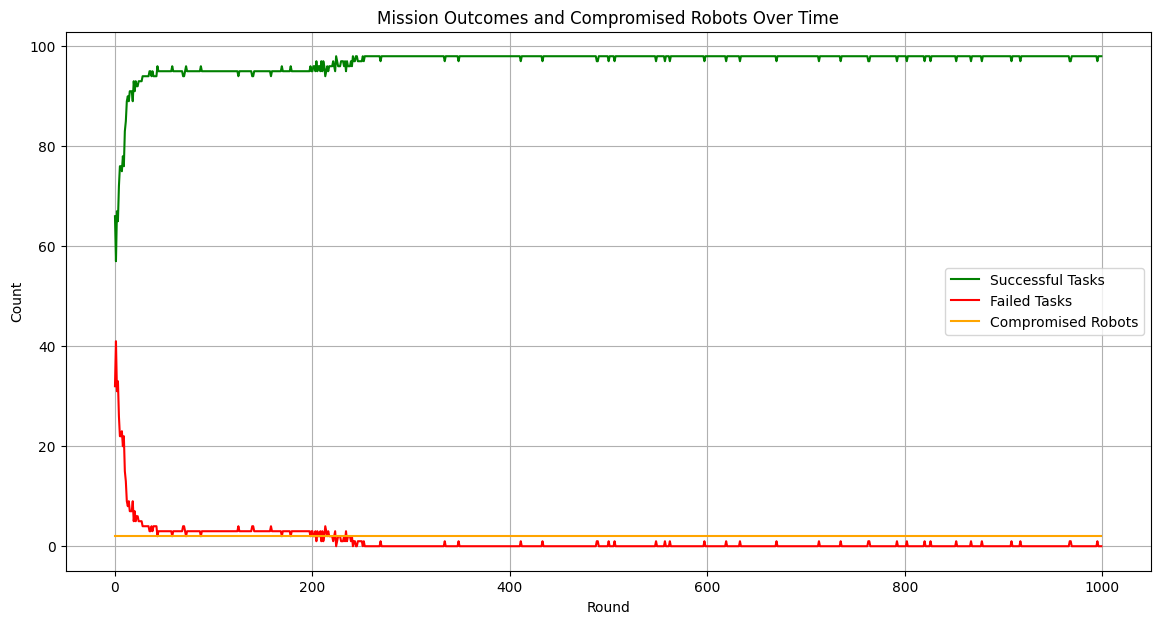

In [123]:
#tracks successes, failures and compromises each round
plt.figure(figsize=(14,7))
plt.plot(range(total_rounds), success_counts, label='Successful Tasks', color='green')
plt.plot(range(total_rounds), fail_counts, label='Failed Tasks', color='red')
plt.plot(range(total_rounds), compromised_counts, label='Compromised Robots', color='orange')
plt.title("Mission Outcomes and Compromised Robots Over Time")
plt.xlabel("Round")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()

### Luke's comments:
So, we have a 10% chance of a robot being compromised, and immediately failing the task resulting in a decrease of 0.05 in trust. If they succeed, their gain in trust is increased by 0.1. Furthermore, Robots start with trust randomly initialized between 0.3 and 0.85, their success depends upon this probability of success.  However, counter measures only can be applied if the robot has had greater than 5 successes, and this recovery is limited to 0.01. This results in a negative feedback loop where the probability of a robot maintaining trust is highly unlikely.  Let's examine a fleet of the average robot:

In [124]:
# Luke's code

average_robot = {
    'trust': np.mean([0.3, 0.85]),
    'trust_history': [np.mean([0.3, 0.85])],
    'compromised': True,
    'success_count': 0,
    'fail_count': 0
}
avg_robots = {}
for i in range(1, num_agents + 1):
  avg_robots[i] = average_robot


for round_num in range(total_rounds):

    #randomly chooses 10% of robots to compromise
    num_compromised = int(num_agents * compromise_rate)
    compromised_ids = random.sample(list(robots.keys()), num_compromised)

    round_compromised = 0
    round_success = 0
    round_fail = 0

    for robot_id in avg_robots:
        robot = avg_robots[robot_id]
        robot['compromised'] = robot_id in compromised_ids
        #checks if the robot is compromised this round
        if robot['compromised']:
          #compromised robot loses trust
            round_compromised += 1
            robot['fail_count'] += 1
            robot['trust'] = max(0.0, robot['trust'] - penalty)
        else:
          #robots try to complete tasks
            if random.random() < robot['trust']:
              #task completed it increases trust
                round_success += 1
                robot['success_count'] += 1
                robot['trust'] = min(1.0, robot['trust'] + reward)
            else:
              #failed tsks decreses trust
                round_fail += 1
                robot['fail_count'] += 1
                robot['trust'] = max(0.0, robot['trust'] - penalty)

        # defense measures -----------------------
        if use_countermeasures:
            #recover if robot has success
            if robot['success_count'] > 5 and robot['trust'] < 0.9:
                robot['trust'] += 0.01

            #trust floor
            if round_num % 200 == 0:
                robot['trust'] = max(robot['trust'], 0.2)

        #logs the round's trust score
        robot['trust_history'].append(robot['trust'])

    #records the rounds stats
    compromised_counts.append(round_compromised)
    success_counts.append(round_success)
    fail_counts.append(round_fail)

print(f"{total_rounds} simulation rounds done")



1000 simulation rounds done


In [125]:
trust_score_list = []
for robot in avg_robots.values():
    trust_score_list.append(robot['trust'])
np.unique(np.array(trust_score_list), return_counts = 1)

(array([1.]), array([100]))

# Luke's comments
So, we have a highly adversarial environment.  This is shown in your visualizations.  A small minority of robots are able to overcome the barrier to becoming more likely than not to succeed, and they are then responsible for the majority of successes.  This isn't necessarily an unrealistic environment, but it's important to understand the majority of robots will become entirely untrustworthy. In fact, the above cell shows that at least half the robots are doomed to failure. Let's find the threshold for a chance of success.

In [126]:
#threshold
starting_trusts = []
final_trusts = []
success_counts_robot = []

#robots trust histories
for robot_id in robots:
    starting_trusts.append(robots[robot_id]['trust_history'][0])
    final_trusts.append(robots[robot_id]['trust_history'][-1])
    success_counts_robot.append(robots[robot_id]['success_count'])

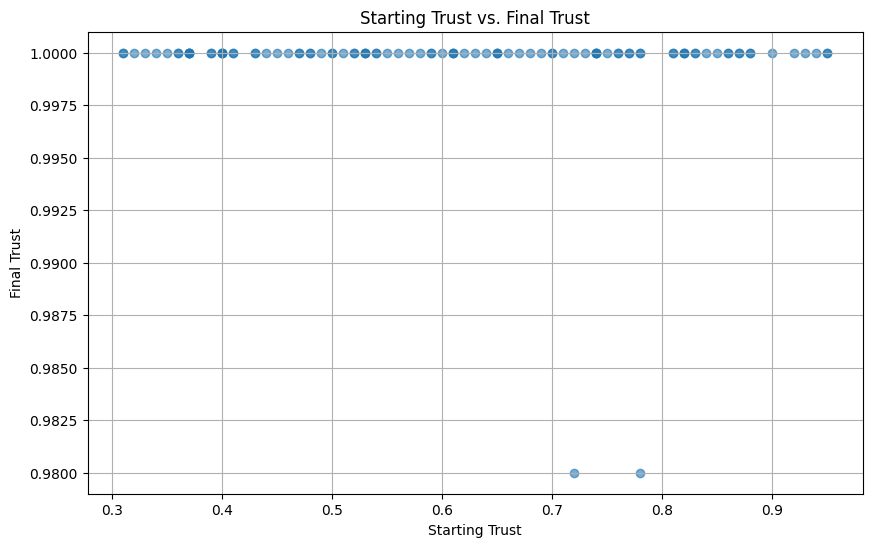

In [127]:
#shows where robots tend to maintain or lsoe trust
plt.figure(figsize=(10,6))
plt.scatter(starting_trusts, final_trusts, alpha=0.6)
plt.title('Starting Trust vs. Final Trust')
plt.xlabel('Starting Trust')
plt.ylabel('Final Trust')
plt.grid()
plt.show()

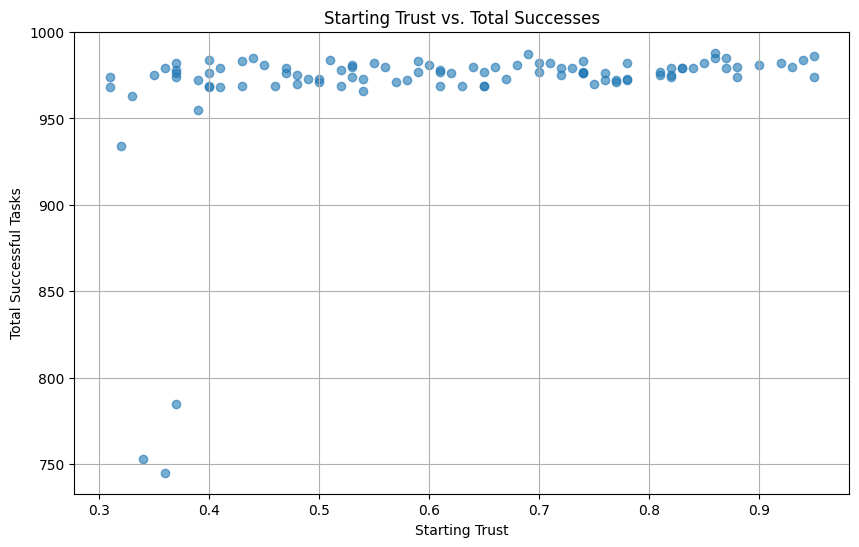

In [128]:
#shows where robots are more likely to succeed overall
plt.figure(figsize=(10,6))
plt.scatter(starting_trusts, success_counts_robot, alpha=0.6)
plt.title('Starting Trust vs. Total Successes')
plt.xlabel('Starting Trust')
plt.ylabel('Total Successful Tasks')
plt.grid()
plt.show()

In [129]:
#thresholds = np.linspace(0.3, 0.85, 56)
#for threshold in thresholds:
# def init_robot(threshold):
#      return {
#          'trust': threshold,
#          'trust_history': [threshold],
#          'compromised': True,
#          'success_count': 0,
#          'fail_count': 0
#      }
#
#  tresh_robots = {i: init_robot(threshold) for i in range(1, num_agents + 1)}

for round_num in range(total_rounds):

    #randomly chooses 10% of robots to compromise
    num_compromised = int(num_agents * compromise_rate)
    compromised_ids = random.sample(list(robots.keys()), num_compromised)
    #compromised_ids = random.sample(list(tresh_robots.keys()), num_compromised)

    round_compromised = 0
    round_success = 0
    round_fail = 0

    for robot_id in robots:
        robot = robots[robot_id]
        robot['compromised'] = robot_id in compromised_ids
        #checks if the robot is compromised this round
        if robot['compromised']:
          #compromised robot loses trust
            round_compromised += 1
            robot['fail_count'] += 1
            robot['trust'] = max(0.0, robot['trust'] - penalty)
        else:
          #robots try to complete tasks
            if random.random() < robot['trust']:
              #task completed it increases trust
                round_success += 1
                robot['success_count'] += 1
                robot['trust'] = min(1.0, robot['trust'] + reward)
            else:
              #failed tsks decreses trust
                round_fail += 1
                robot['fail_count'] += 1
                robot['trust'] = max(0.0, robot['trust'] - penalty)

        # defense measures -----------------------
        if use_countermeasures:
            #recover if robot has success
            if robot['success_count'] > 5 and robot['trust'] < 0.9:
                robot['trust'] += 0.01

            #trust floor
            if round_num % 200 == 0:
                robot['trust'] = max(robot['trust'], 0.2)

        #logs the round's trust score
        robot['trust_history'].append(robot['trust'])

    #records the rounds stats
    compromised_counts.append(round_compromised)
    success_counts.append(round_success)
    fail_counts.append(round_fail)

print(f"{total_rounds} simulation rounds done")

#  trust_score_list = []
#  for robot in tresh_robots.values():
#      trust_score_list.append(robot['trust'])
#  print(f"Threshold: {threshold:.2f} Trust counts: {np.unique(np.array(trust_score_list), return_counts = 1)}")

1000 simulation rounds done


# Luke's comments:
So, we don't see any successful robots until a robots trust is initialized to 49% in this little test. We see something like an even distribution in the mid to lower 60's for initialization values.  However, tha majority of your robots are initialized at 53% initial trust and below.  Additionally, about 10% of your robots starting with the highest trust still become nearly entirely untrustworthy.  I'm not criticizing.  Developing a stable system is difficult.  This explains why your graphs look so much like there's winners and losers.  maybe we should try more balanced rewards and punishments.  It would be more work, but you might consider balancing the system with adjustable parameters before introducing the compromise element.  Additionally, 10% chance of compromise seems a little high.  I would imagine we would want to see robots typically being capable of completing tasks.  Perhaps a failure chance less than 20%.  However, compromise should likely be enduring from epoch to epoch.  That is, once a robot is compromised, they remain compromised and are far less likely to complete their tasks. I guess I'm assuming 'compromised' relates to external tampering.  If it's just another way of introducing random chance of failure, you're kind of just multiplying your random chance of failure.

trust matrix, applying poisoning/defense, and qubo

In [130]:
#used neal -------------
#finding a good solution
def solve_qubo_neal(qubo):
  #convert qubo to binaryquadraticmodel
    bqm = dimod.BinaryQuadraticModel.from_qubo(qubo)
    sampler = dimod.SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=100)
    #return best solution
    best_sample = sampleset.first.sample
    return best_sample

In [131]:
#converts flat binary soultion into agent-task assignment matrix
def decode_solution(best_sample, num_agents, num_tasks):
    assignment = np.zeros((num_agents, num_tasks), dtype=int)
    for i in range(num_agents):
        for j in range(num_tasks):
            idx = i * num_tasks + j
            assignment[i, j] = best_sample[idx]
    return assignment

#**07/03 Changes**

Modified the encouragement term to scale with trust, i think.

In [132]:
#qubo matrix for assignment problem
def build_qubo_improved(trust_matrix, lambda_penalty=50.0, encouragement=0.5, static_mask=None):
    num_agents, num_tasks = trust_matrix.shape
    N = num_agents * num_tasks
    qubo = np.zeros((N, N))

    #encourage high trust assignments (subtracting trust and encouragement)
    for i in range(num_agents):
        for j in range(num_tasks):
            idx = i * num_tasks + j

            #encouragement proportional to trust --------------------------
            qubo[idx, idx] = -trust_matrix[i, j] - encouragement * trust_matrix[i, j]

    #hard contraints, one task per agent -----------------
    #penalize multiple task assignments for the same agent
    for i in range(num_agents):
        for j1 in range(num_tasks):
            for j2 in range(num_tasks):
                idx1 = i * num_tasks + j1
                idx2 = i * num_tasks + j2
                if idx1 == idx2:
                    qubo[idx1, idx1] += lambda_penalty * (-2)
                else:
                    qubo[idx1, idx2] += lambda_penalty * 2

    #hard constraints, one agent per task -------------------
    #penalize mutiple agents being assigned to the same task
    for j in range(num_tasks):
        for i1 in range(num_agents):
            for i2 in range(num_agents):
                idx1 = i1 * num_tasks + j
                idx2 = i2 * num_tasks + j
                if idx1 == idx2:
                    qubo[idx1, idx1] += lambda_penalty * (-2)
                else:
                    qubo[idx1, idx2] += lambda_penalty * 2

    #block assignments
    if static_mask is not None:
        for i in range(num_agents):
            for j in range(num_tasks):
                if static_mask[i][j] == 0:
                    idx = i * num_tasks + j
                    #large penalty to block
                    qubo[idx, idx] += 1000 * lambda_penalty

    return qubo

# Luke's comments:
I worry a little about this encouragement factor.  I understand what you're trying to do, but this might promote the assignment of tasks to low-trust robots.  It should be relative to trust in some manner.

#**07/03 Changes**

replaced my random sampling of agents with stratified sampling, bining agents by trust level i think

In [133]:
#robot's trust score multipled by task difficulty
agent_trust_vector = np.array([robots[robot_id]['trust'] for robot_id in robots])
num_tasks = 100

#difficulty for each task (random values)
task_difficulty_vector = np.random.uniform(0.8, 1.0, size=num_tasks)

#100x100 agent-task trust matrix
trust_matrix_full = np.outer(agent_trust_vector, task_difficulty_vector)

#submatrix for qubo
num_agents_qubo = 5
num_tasks_qubo = 5

#trust scores for all agents
agent_trust_scores = np.array([robots[robot_id]['trust'] for robot_id in robots])

#bin agents by thier trust levels
low_trust = [i for i, t in enumerate(agent_trust_scores) if t < 0.4]
medlow_trust = [i for i, t in enumerate(agent_trust_scores) if 0.4 <= t < 0.6]
medhigh_trust = [i for i, t in enumerate(agent_trust_scores) if 0.6 <= t < 0.8]
high_trust = [i for i, t in enumerate(agent_trust_scores) if t >= 0.8]

#makes sure there is trust distribution
sampled_indices = []
if len(low_trust) > 0:
    sampled_indices += random.sample(low_trust, min(1, len(low_trust)))
if len(medlow_trust) > 0:
    sampled_indices += random.sample(medlow_trust, min(1, len(medlow_trust)))
if len(medhigh_trust) > 0:
    sampled_indices += random.sample(medhigh_trust, min(1, len(medhigh_trust)))
if len(high_trust) > 0:
    sampled_indices += random.sample(high_trust, min(1, len(high_trust)))

#fill remainder slots
remaining_needed = 5 - len(sampled_indices)
if remaining_needed > 0:
    all_indices = list(range(num_agents))
    remaining_pool = [i for i in all_indices if i not in sampled_indices]
    sampled_indices += random.sample(remaining_pool, remaining_needed)

#selected for submatrix
agents_indices = sampled_indices
#randomly select 5 task
tasks_indices = np.random.choice(range(num_tasks), num_tasks_qubo, replace=False)

#extracts the submatrix
trust_matrix_qubo = trust_matrix_full[np.ix_(agents_indices, tasks_indices)]

#baseline
print("Baseline Trust Matrix")
print(trust_matrix_qubo)

print("\n")

#poisoning attack by lowering trust scores for one agent
poisoned_trust_matrix_qubo = trust_matrix_qubo.copy()

#reduce trust for all
attack_noise = np.random.uniform(0.3, 0.5, size=poisoned_trust_matrix_qubo.shape)
poisoned_trust_matrix_qubo -= attack_noise
print("Poisoned Trust Matrix")
print(poisoned_trust_matrix_qubo)

print("\n")

#defense by partially restoring low trust scores
defense_trust_matrix_qubo = poisoned_trust_matrix_qubo.copy()
for i in range(num_agents_qubo):
    for j in range(num_tasks_qubo):
        if defense_trust_matrix_qubo[i, j] < 0.6:
            defense_trust_matrix_qubo[i, j] += 0.2
defense_trust_matrix_qubo = np.clip(defense_trust_matrix_qubo, 0, 1)
print("Defended Trust Matrix")
print(defense_trust_matrix_qubo)

Baseline Trust Matrix
[[0.80440209 0.90081459 0.84012501 0.89284929 0.9036366 ]
 [0.80440209 0.90081459 0.84012501 0.89284929 0.9036366 ]
 [0.80440209 0.90081459 0.84012501 0.89284929 0.9036366 ]
 [0.80440209 0.90081459 0.84012501 0.89284929 0.9036366 ]
 [0.80440209 0.90081459 0.84012501 0.89284929 0.9036366 ]]


Poisoned Trust Matrix
[[0.46502386 0.44775522 0.53387184 0.56857179 0.41776617]
 [0.3186369  0.52570557 0.52939444 0.51001048 0.46476112]
 [0.40246158 0.52693565 0.37698304 0.44087251 0.48858688]
 [0.38947209 0.49879533 0.46580607 0.46775378 0.59698609]
 [0.50358346 0.5940759  0.48087015 0.40720667 0.4608632 ]]


Defended Trust Matrix
[[0.66502386 0.64775522 0.73387184 0.76857179 0.61776617]
 [0.5186369  0.72570557 0.72939444 0.71001048 0.66476112]
 [0.60246158 0.72693565 0.57698304 0.64087251 0.68858688]
 [0.58947209 0.69879533 0.66580607 0.66775378 0.79698609]
 [0.70358346 0.7940759  0.68087015 0.60720667 0.6608632 ]]


# Luke's comments
Your random sample might not capture the full range of trust.  Consider a stratified sample based on agent trust scores where you consider the distribution of trust scores among the population, and pull a sample that has a similar distribution.

#**07/03 Changes**

Normalizes each trust matrix before scaling, should have consistent scaling

In [134]:
scale_factor = 20

#baseline, normalize and scale
normalized_trust_matrix_qubo = trust_matrix_qubo / np.max(trust_matrix_qubo)
trust_matrix_qubo_rescaled = normalized_trust_matrix_qubo * scale_factor

#poisoned, normalize and scale
normalized_poisoned_trust_matrix_qubo = poisoned_trust_matrix_qubo / np.max(poisoned_trust_matrix_qubo)
poisoned_trust_matrix_qubo_rescaled = normalized_poisoned_trust_matrix_qubo * scale_factor

#defended, normalize and scale
normalized_defense_trust_matrix_qubo = defense_trust_matrix_qubo / np.max(defense_trust_matrix_qubo)
defense_trust_matrix_qubo_rescaled = normalized_defense_trust_matrix_qubo * scale_factor

#select from the full fleet for comparison
baseline_trust_matrix = agent_trust_vector[:, np.newaxis] * task_difficulty_vector[np.newaxis, :]
baseline_trust_matrix_rescaled = baseline_trust_matrix * scale_factor

#baseline sample
sample_agents = np.random.choice(num_agents, 5, replace=False)
sample_tasks = np.random.choice(num_tasks, 5, replace=False)

#extract from baseline sample
baseline_trust_matrix_sampled = baseline_trust_matrix_rescaled[np.ix_(sample_agents, sample_tasks)]
poisoned_trust_matrix_sampled = poisoned_trust_matrix_qubo_rescaled
defended_trust_matrix_sampled = defense_trust_matrix_qubo_rescaled

# Luke's comments:
I see what you're doing with the scale factor here, but I might normalize my trust matrix first so scaled matrices are comparable.  i.e.

```
normalized_trust_matrix_qubo = (1/np.max(trust_matrix_quob)) * trust_matrix_qubo
```

In [135]:
#dimensions for submatrix
num_agents_qubo = 5
num_tasks_qubo = 5

In [136]:
#assignments that are allowed (1) or blocked (0)
static_mask = np.ones((num_agents_qubo, num_tasks_qubo))
#block agent 2 from doing task 3
static_mask[1, 2] = 0

#increased penalty -------
lambda_penalty = 50.0
encouragement = 0.5

#three scenarios

#baseline (control)
qubo_baseline = build_qubo_improved(baseline_trust_matrix_sampled, lambda_penalty, encouragement, static_mask)
sol_baseline = solve_qubo_neal(qubo_baseline)
assign_baseline = decode_solution(sol_baseline, num_agents_qubo, num_tasks_qubo)

#poisoned (trust degraded for one agent row)
qubo_poisoned = build_qubo_improved(poisoned_trust_matrix_qubo_rescaled, lambda_penalty, encouragement, static_mask)
sol_poisoned = solve_qubo_neal(qubo_poisoned)
assign_poisoned = decode_solution(sol_poisoned, num_agents_qubo, num_tasks_qubo)

#defended
qubo_defended = build_qubo_improved(defense_trust_matrix_qubo_rescaled, lambda_penalty, encouragement, static_mask)
sol_defended = solve_qubo_neal(qubo_defended)
assign_defended = decode_solution(sol_defended, num_agents_qubo, num_tasks_qubo)

In [137]:
#showing the matrices
print("Baseline QUBO Assignment Matrix")
print(assign_baseline)

print("\n")

print("Poisoned QUBO Assignment Matrix")
print(assign_poisoned)

print("\n")

print("Defended QUBO Assignment Matrix")
print(assign_defended)

Baseline QUBO Assignment Matrix
[[0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 1 0 0]]


Poisoned QUBO Assignment Matrix
[[0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


Defended QUBO Assignment Matrix
[[0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


In [138]:
#getting overall trust reward
total_trust_poisoned = np.sum(assign_poisoned * poisoned_trust_matrix_qubo_rescaled)
total_trust_defended = np.sum(assign_defended * defense_trust_matrix_qubo_rescaled)

print("Total Trust Reward (Poisoned):", total_trust_poisoned)
print("Total Trust Reward (Defended):", total_trust_defended)

Total Trust Reward (Poisoned): 87.13836132334265
Total Trust Reward (Defended): 89.63343272330073


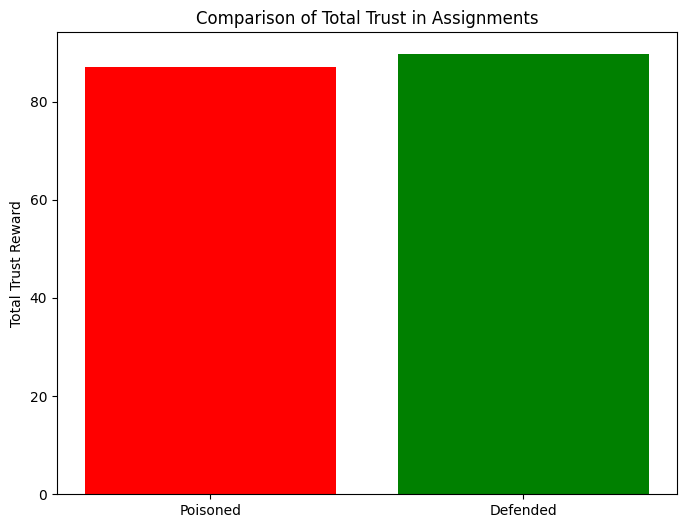

In [139]:
#shows comparison
plt.figure(figsize=(8,6))
plt.bar(['Poisoned', 'Defended'], [total_trust_poisoned, total_trust_defended], color=['red', 'green'])
plt.ylabel('Total Trust Reward')
plt.title('Comparison of Total Trust in Assignments')
plt.show()

# Luke's comments:
This lambda penalty seems a reasonable starting place.  It should dominate.  I haven't done the math though.  If you're making changes to your data generation scheme, do those first.  Then, I would run a quick ablation studty for lambda penalties = \[25, 50, 75, 100, 150, 200\] or something like that.  You might not need to run the full dataset, but you should get a quick idea of what works.  If you've already done something similar, disregard.

In [140]:
#redefining
static_mask = np.ones((num_agents_qubo, num_tasks_qubo))
static_mask[1, 2] = 0

lambda_penalty = 50.0
encouragement = 0.5

In [141]:
#comparing three scenarios
total_trust_baseline = np.sum(assign_baseline * baseline_trust_matrix_sampled)
total_trust_poisoned = np.sum(assign_poisoned * poisoned_trust_matrix_sampled)
total_trust_defended = np.sum(assign_defended * defended_trust_matrix_sampled)

print("\nTotal Trust Reward (Baseline):", total_trust_baseline)
print("Total Trust Reward (Poisoned):", total_trust_poisoned)
print("Total Trust Reward (Defended):", total_trust_defended)


Total Trust Reward (Baseline): 89.82774939296606
Total Trust Reward (Poisoned): 87.13836132334265
Total Trust Reward (Defended): 89.63343272330073


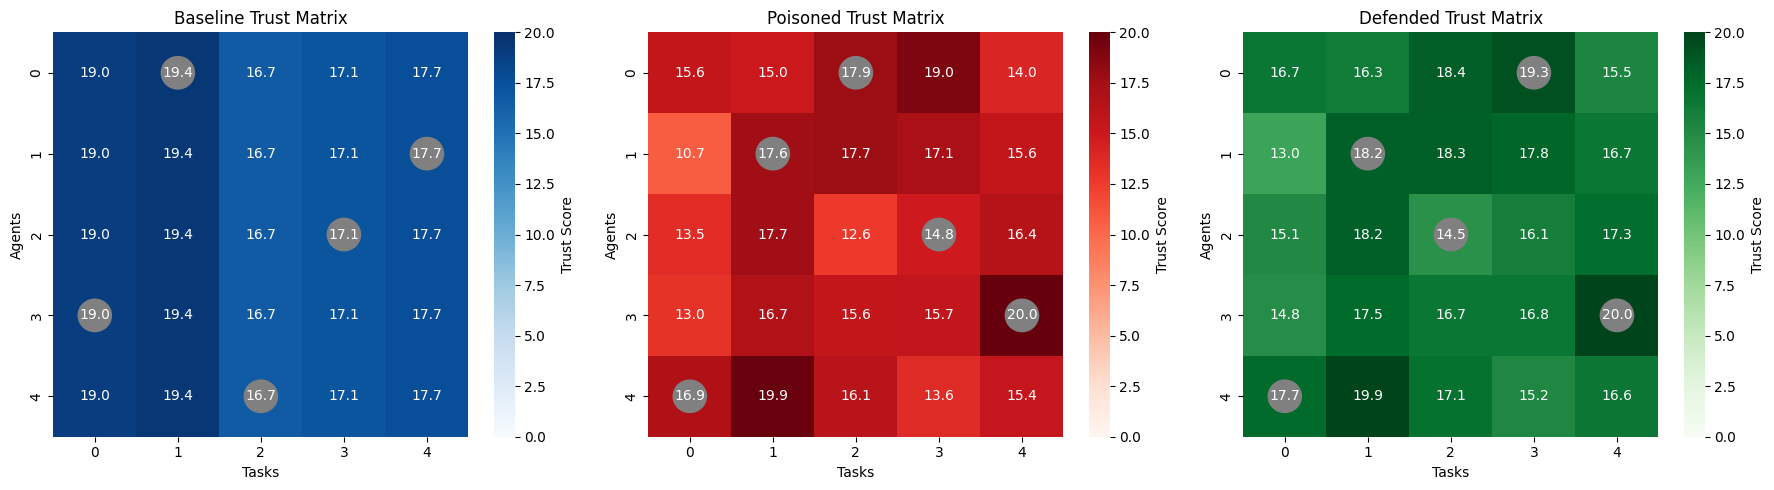

In [142]:
#shows trust matrices with assignments marked
plt.figure(figsize=(18,5))

# Define shared color scale
vmin = 0
vmax = 20

#baseline
plt.subplot(1,3,1)
ax = sns.heatmap(baseline_trust_matrix_sampled, annot=True, fmt=".1f",
                  cmap='Blues', cbar=True, vmin=vmin, vmax=vmax)
plt.title('Baseline Trust Matrix')
plt.xlabel('Tasks')
plt.ylabel('Agents')
cbar = ax.collections[0].colorbar
cbar.set_label('Trust Score')
for i in range(assign_baseline.shape[0]):
    for j in range(assign_baseline.shape[1]):
        if assign_baseline[i, j] == 1:
            ax.add_patch(plt.Circle((j + 0.5, i + 0.5), 0.2, color='grey'))

#poisoned
plt.subplot(1,3,2)
ax = sns.heatmap(poisoned_trust_matrix_sampled, annot=True, fmt=".1f",
                  cmap='Reds', cbar=True, vmin=vmin, vmax=vmax)
plt.title('Poisoned Trust Matrix')
plt.xlabel('Tasks')
plt.ylabel('Agents')
cbar = ax.collections[0].colorbar
cbar.set_label('Trust Score')
for i in range(assign_poisoned.shape[0]):
    for j in range(assign_poisoned.shape[1]):
        if assign_poisoned[i, j] == 1:
            ax.add_patch(plt.Circle((j + 0.5, i + 0.5), 0.2, color='grey'))

#defended
plt.subplot(1,3,3)
ax = sns.heatmap(defended_trust_matrix_sampled, annot=True, fmt=".1f",
                  cmap='Greens', cbar=True, vmin=vmin, vmax=vmax)
plt.title('Defended Trust Matrix')
plt.xlabel('Tasks')
plt.ylabel('Agents')
cbar = ax.collections[0].colorbar
cbar.set_label('Trust Score')
for i in range(assign_defended.shape[0]):
    for j in range(assign_defended.shape[1]):
        if assign_defended[i, j] == 1:
            ax.add_patch(plt.Circle((j + 0.5, i + 0.5), 0.2, color='grey'))

plt.tight_layout()
plt.show()

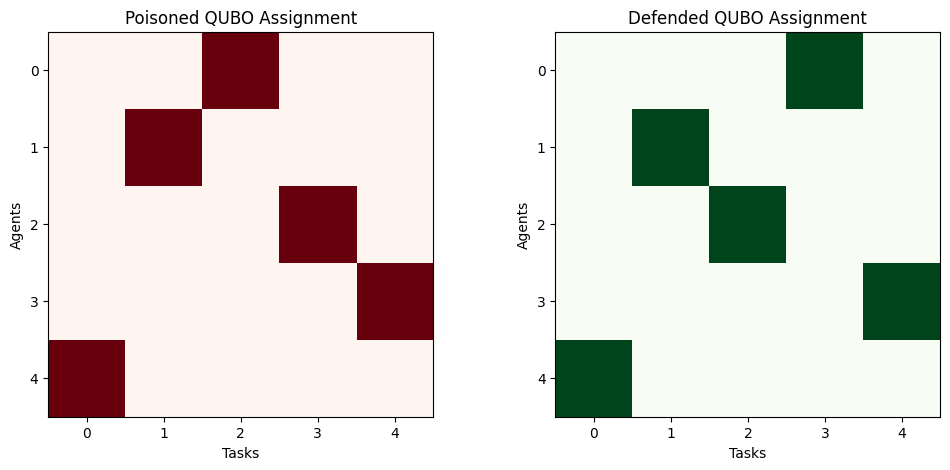

In [143]:
#shows which cells in the assignment matrices are 1
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(assign_poisoned, cmap='Reds')
plt.title('Poisoned QUBO Assignment')
plt.xlabel('Tasks')
plt.ylabel('Agents')

plt.subplot(1,2,2)
plt.imshow(assign_defended, cmap='Greens')
plt.title('Defended QUBO Assignment')
plt.xlabel('Tasks')
plt.ylabel('Agents')
plt.show()